In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder,LabelEncoder,StandardScaler
from sklearn.metrics import roc_curve,auc
from sklearn.model_selection import StratifiedKFold

import string
import warnings
warnings.filterwarnings('ignore')
SEED=42


In [2]:
def concat_df(train_data,test_data):
    return pd.concat([train_data,test_data],sort=True).reset_index(drop=True)
def divide_df(all_data):
    return all_data.loc[:890],all_data.loc[891:].drop(["Survived"],axis=1)

df_train=pd.read_csv('/kaggle/input/titanic/train.csv')
df_test=pd.read_csv('/kaggle/input/titanic/test.csv')
df_all=concat_df(df_train,df_test)

df_train.name='Training Set'
df_test.name='Test Set'
df_all.name='All Set'

dfs=[df_train,df_test]

print('Number of Traing Ecamples = {}'.format(df_train.shape[0]))
print('Number of Test Examples={}\n'.format(df_test.shape[0]))
print('Training X Shape = {}'.format(df_train.shape))
print('Training y Shape = {}\n'.format(df_train['Survived'].shape[0]))

print('Test X Shape = {}'.format(df_test.shape))
print('Test y Shape = {}\n'.format(df_test.shape[0]))
print(df_train.columns)
print(df_test.columns)
print()

Number of Traing Ecamples = 891
Number of Test Examples=418

Training X Shape = (891, 12)
Training y Shape = 891

Test X Shape = (418, 11)
Test y Shape = 418

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')



In [3]:
print(df_train.info())
df_train.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
111,112,0,3,"Zabour, Miss. Hileni",female,14.5,1,0,2665,14.4542,NaN,C
812,813,0,2,"Slemen, Mr. Richard James",male,35.0,0,0,28206,10.5000,NaN,S
130,131,0,3,"Drazenoic, Mr. Jozef",male,33.0,0,0,349241,7.8958,NaN,C


In [4]:
df_all['Age'] = df_all.groupby(['Sex', 'Pclass'])['Age'].transform(lambda x: x.fillna(x.median()))

In [5]:
df_all['Embarked'] = df_all['Embarked'].fillna('S')

In [6]:
med_fare = df_all.groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()[3][0][0]
# Filling the missing value in Fare with the median Fare of 3rd class alone passenger
df_all['Fare'] = df_all['Fare'].fillna(med_fare)

In [7]:
df_all['Deck'] = df_all['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')
idx = df_all[df_all['Deck'] == 'T'].index
df_all.loc[idx, 'Deck'] = 'A'

In [8]:
df_all['Deck'] = df_all['Deck'].replace(['A', 'B', 'C'], 'ABC')
df_all['Deck'] = df_all['Deck'].replace(['D', 'E'], 'DE')
df_all['Deck'] = df_all['Deck'].replace(['F', 'G'], 'FG')

df_all['Deck'].value_counts()

Deck
M      1014
ABC     182
DE       87
FG       26
Name: count, dtype: int64

In [9]:
df_all.drop(['Cabin'], inplace=True, axis=1)

df_train, df_test = divide_df(df_all)
dfs = [df_train, df_test]

In [10]:
df_all = concat_df(df_train, df_test)
df_all.head()

,Age,Deck,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,M,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,ABC,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,M,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,ABC,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,M,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


In [11]:
df_all['Fare'] = pd.qcut(df_all['Fare'], 13)

In [12]:
df_all['Age'] = pd.qcut(df_all['Age'], 10)

In [13]:
df_all['Family_Size'] = df_all['SibSp'] + df_all['Parch'] + 1
family_map = {1: 'Alone', 2: 'Small', 3: 'Small', 4: 'Small', 5: 'Medium', 6: 'Medium', 7: 'Large', 8: 'Large', 11: 'Large'}
df_all['Family_Size_Grouped'] = df_all['Family_Size'].map(family_map)

In [14]:
df_all['Ticket_Frequency'] = df_all.groupby('Ticket')['Ticket'].transform('count')

In [15]:
df_all['Title'] = df_all['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
df_all['Is_Married'] = 0
df_all['Is_Married'].loc[df_all['Title'] == 'Mrs'] = 1
df_all['Title'] = df_all['Title'].replace(['Miss', 'Mrs','Ms', 'Mlle', 'Lady', 'Mme', 'the Countess', 'Dona'], 'Miss/Mrs/Ms')
df_all['Title'] = df_all['Title'].replace(['Dr', 'Col', 'Major', 'Jonkheer', 'Capt', 'Sir', 'Don', 'Rev'], 'Dr/Military/Noble/Clergy')


In [16]:
def extract_surname(data):    
    
    families = []
    
    for i in range(len(data)):        
        name = data.iloc[i]

        if '(' in name:
            name_no_bracket = name.split('(')[0] 
        else:
            name_no_bracket = name
            
        family = name_no_bracket.split(',')[0]
        title = name_no_bracket.split(',')[1].strip().split(' ')[0]
        
        for c in string.punctuation:
            family = family.replace(c, '').strip()
            
        families.append(family)
            
    return families

df_all['Family'] = extract_surname(df_all['Name'])
df_train = df_all.loc[:890]
df_test = df_all.loc[891:]
dfs = [df_train, df_test]

In [17]:
non_unique_families = [x for x in df_train['Family'].unique() if x in df_test['Family'].unique()]
non_unique_tickets = [x for x in df_train['Ticket'].unique() if x in df_test['Ticket'].unique()]

df_family_survival_rate = df_train[['Survived', 'Family','Family_Size']].groupby('Family').median()
df_ticket_survival_rate = df_train[['Survived', 'Ticket','Ticket_Frequency']].groupby('Ticket').median()


family_rates = {}
ticket_rates = {}

for i in range(len(df_family_survival_rate)):
    # Checking a family exists in both training and test set, and has members more than 1
    if df_family_survival_rate.index[i] in non_unique_families and df_family_survival_rate.iloc[i, 1] > 1:
        family_rates[df_family_survival_rate.index[i]] = df_family_survival_rate.iloc[i, 0]

for i in range(len(df_ticket_survival_rate)):
    # Checking a ticket exists in both training and test set, and has members more than 1
    if df_ticket_survival_rate.index[i] in non_unique_tickets and df_ticket_survival_rate.iloc[i, 1] > 1:
        ticket_rates[df_ticket_survival_rate.index[i]] = df_ticket_survival_rate.iloc[i, 0]

In [18]:
mean_survival_rate = np.mean(df_train['Survived'])

train_family_survival_rate = []
train_family_survival_rate_NA = []
test_family_survival_rate = []
test_family_survival_rate_NA = []

for i in range(len(df_train)):
    if df_train['Family'][i] in family_rates:
        train_family_survival_rate.append(family_rates[df_train['Family'][i]])
        train_family_survival_rate_NA.append(1)
    else:
        train_family_survival_rate.append(mean_survival_rate)
        train_family_survival_rate_NA.append(0)

for i in range(len(df_test)):
    if df_test['Family'].iloc[i] in family_rates:
        test_family_survival_rate.append(family_rates[df_test['Family'].iloc[i]])
        test_family_survival_rate_NA.append(1)
    else:
        test_family_survival_rate.append(mean_survival_rate)
        test_family_survival_rate_NA.append(0)
        
df_train['Family_Survival_Rate'] = train_family_survival_rate
df_train['Family_Survival_Rate_NA'] = train_family_survival_rate_NA
df_test['Family_Survival_Rate'] = test_family_survival_rate
df_test['Family_Survival_Rate_NA'] = test_family_survival_rate_NA

train_ticket_survival_rate = []
train_ticket_survival_rate_NA = []
test_ticket_survival_rate = []
test_ticket_survival_rate_NA = []

for i in range(len(df_train)):
    if df_train['Ticket'][i] in ticket_rates:
        train_ticket_survival_rate.append(ticket_rates[df_train['Ticket'][i]])
        train_ticket_survival_rate_NA.append(1)
    else:
        train_ticket_survival_rate.append(mean_survival_rate)
        train_ticket_survival_rate_NA.append(0)
        
for i in range(len(df_test)):
    if df_test['Ticket'].iloc[i] in ticket_rates:
        test_ticket_survival_rate.append(ticket_rates[df_test['Ticket'].iloc[i]])
        test_ticket_survival_rate_NA.append(1)
    else:
        test_ticket_survival_rate.append(mean_survival_rate)
        test_ticket_survival_rate_NA.append(0)

df_train['Ticket_Survival_Rate'] = train_ticket_survival_rate
df_train['Ticket_Survival_Rate_NA'] = train_ticket_survival_rate_NA
df_test['Ticket_Survival_Rate'] = test_ticket_survival_rate
df_test['Ticket_Survival_Rate_NA'] = test_ticket_survival_rate_NA

In [19]:
for df in [df_train,df_test]:
    df['Survival_Rate'] = (df['Ticket_Survival_Rate'] + df['Family_Survival_Rate']) / 2
    df['Survival_Rate_NA'] = (df['Ticket_Survival_Rate_NA'] + df['Family_Survival_Rate_NA']) / 2 

In [20]:
non_numeric_features = ['Embarked', 'Sex', 'Deck', 'Title', 'Family_Size_Grouped', 'Age', 'Fare']

for df in dfs:
    for feature in non_numeric_features:        
        df[feature] = LabelEncoder().fit_transform(df[feature])

In [21]:
cat_features = ['Pclass', 'Sex', 'Deck', 'Embarked', 'Title', 'Family_Size_Grouped']
encoded_features = []

for df in dfs:
    for feature in cat_features:
        encoded_feat = OneHotEncoder().fit_transform(df[feature].values.reshape(-1, 1)).toarray()
        n = df[feature].nunique()
        cols = ['{}_{}'.format(feature, n) for n in range(1, n + 1)]
        encoded_df = pd.DataFrame(encoded_feat, columns=cols)
        encoded_df.index = df.index
        encoded_features.append(encoded_df)

df_train = pd.concat([df_train, *encoded_features[:6]], axis=1)
df_test = pd.concat([df_test, *encoded_features[6:]], axis=1)

In [22]:
df_all = concat_df(df_train, df_test)
drop_cols = ['Deck', 'Embarked', 'Family', 'Family_Size', 'Family_Size_Grouped', 'Survived',
             'Name', 'Parch', 'PassengerId', 'Pclass', 'Sex', 'SibSp', 'Ticket', 'Title',
            'Ticket_Survival_Rate', 'Family_Survival_Rate', 'Ticket_Survival_Rate_NA', 'Family_Survival_Rate_NA']

df_all.drop(columns=drop_cols, inplace=True)

df_all.head()

,Age,Deck_1,Deck_2,Deck_3,Deck_4,Embarked_1,Embarked_2,Embarked_3,Family_Size_Grouped_1,Family_Size_Grouped_2,...,Pclass_3,Sex_1,Sex_2,Survival_Rate,Survival_Rate_NA,Ticket_Frequency,Title_1,Title_2,Title_3,Title_4
0,2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.383838,0.0,1,0.0,0.0,0.0,1.0
1,7,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.000000,1.0,2,0.0,0.0,1.0,0.0
2,4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,1.0,0.0,0.383838,0.0,1,0.0,0.0,1.0,0.0
3,7,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.383838,0.0,2,0.0,0.0,1.0,0.0
4,7,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,1.0,0.383838,0.0,1,0.0,0.0,0.0,1.0


模型：


In [23]:
X_train=StandardScaler().fit_transform(df_train.drop(columns=drop_cols))
y_train=df_train['Survived'].values
X_test=StandardScaler().fit_transform(df_test.drop(columns=drop_cols))


In [24]:
single_best_model=RandomForestClassifier(criterion='gini',
                                        n_estimators=1100,
                                        max_depth=5,
                                        min_samples_split=4,
                                        min_samples_leaf=5,
                                        max_features='auto',
                                        oob_score=True,
                                        random_state=SEED,
                                        n_jobs=1,
                                        verbose=1)
leaderboard_model=RandomForestClassifier(criterion='gini',
                                        n_estimators=1750,
                                        max_depth=7,
                                        min_samples_split=6,
                                        min_samples_leaf=6,
                                        max_features='auto',
                                        oob_score=True,
                                        random_state=SEED,
                                        n_jobs=-1,
                                        verbose=1)


In [25]:
N=5
oob=0
probs = pd.DataFrame(np.zeros((len(X_test), N * 2)), columns=['Fold_{}_Prob_{}'.format(i, j) for i in range(1, N + 1) for j in range(2)])
importances = pd.DataFrame(np.zeros((X_train.shape[1], N)), columns=['Fold_{}'.format(i) for i in range(1, N + 1)], index=df_all.columns)
fprs,tprs,scores=[],[],[]

skf=StratifiedKFold(n_splits=N,random_state=N,shuffle=True)
for fold,(trn_idx,val_idx)in enumerate(skf.split(X_train,y_train),1):
    print('Fold {}\n'.format(fold))
    leaderboard_model.fit(X_train[trn_idx],y_train[trn_idx])
    trn_fpr,trn_tpr,trn_thresholds=roc_curve(y_train[trn_idx],leaderboard_model.predict_proba(X_train[trn_idx])[:,1])
    trn_auc_score=auc(trn_fpr,trn_tpr)

    val_fpr,val_tpr,val_threshoulds=roc_curve(y_train[val_idx],leaderboard_model.predict_proba(X_train[val_idx])[:,1])
    val_auc_score=auc(val_fpr,val_tpr)

    scores.append((trn_auc_score,val_auc_score))
    fprs.append(val_fpr)
    tprs.append(val_tpr)
    probs.loc[:,'Fold_{}_Prob_0'.format(fold)]=leaderboard_model.predict_proba(X_test)[:,0]
    probs.loc[:,'Fold_{}_Prob_1'.format(fold)]=leaderboard_model.predict_proba(X_test)[:,1]
    importances.iloc[:, fold - 1] = leaderboard_model.feature_importances_
        
    oob += leaderboard_model.oob_score_ / N
print(oob)

Fold 1



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    3.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 1750 out of 1750 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent worker

Fold 2



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    3.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 1750 out of 1750 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent worker

Fold 3



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    3.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 1750 out of 1750 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent worker

Fold 4



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    3.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 1750 out of 1750 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent worker

Fold 5



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    3.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 1750 out of 1750 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent worker

0.8425961674834928


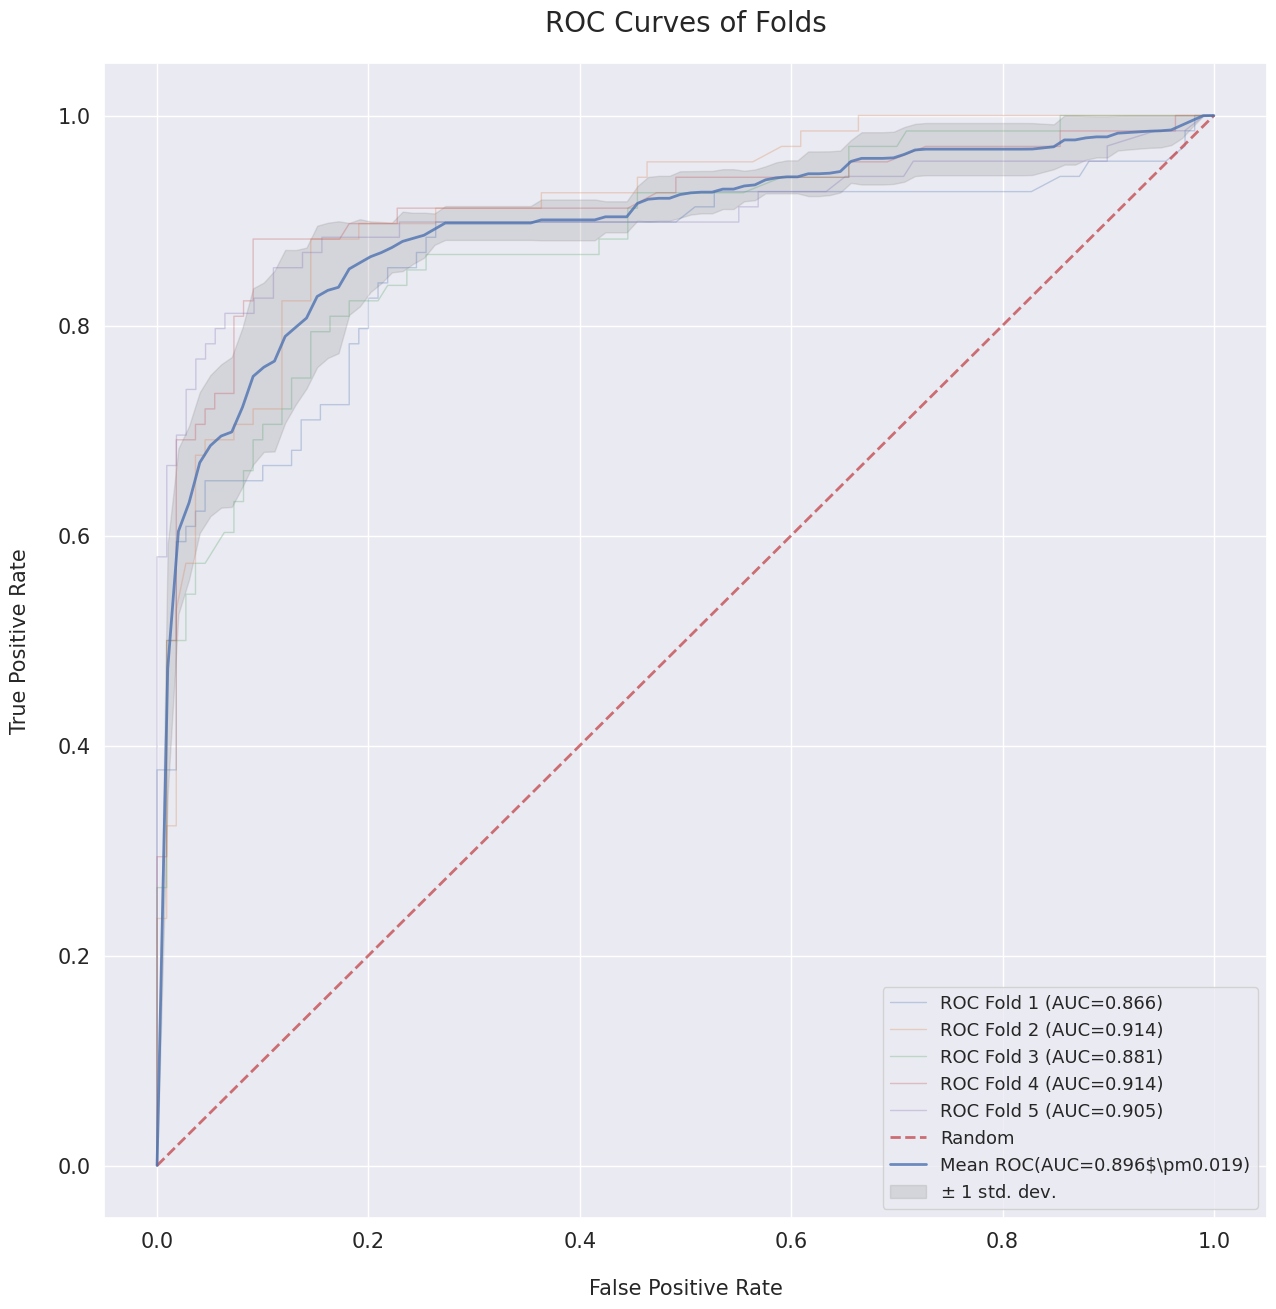

In [26]:
def plot_roc_curve(fprs,tprs):
    tprs_interp=[]
    aucs=[]
    mean_fpr=np.linspace(0,1,100)
    f,ax=plt.subplots(figsize=(15,15))

    for i,(fpr,tpr) in enumerate(zip(fprs,tprs),1):
        tprs_interp.append(np.interp(mean_fpr,fpr,tpr))
        tprs_interp[-1][0]=0.0
        roc_auc=auc(fpr,tpr)
        aucs.append(roc_auc)
        ax.plot(fpr,tpr,lw=1,alpha=0.3,label='ROC Fold {} (AUC={:.3f})'.format(i,roc_auc))
    plt.plot([0,1],[0,1],linestyle='--',lw=2,color='r',alpha=0.8,label='Random')
    mean_tpr=np.mean(tprs_interp,axis=0)
    mean_tpr[-1]=1.0
    mean_auc=auc(mean_fpr,mean_tpr)
    std_auc=np.std(aucs)
    ax.plot(mean_fpr,mean_tpr,color='b',label="Mean ROC(AUC={:.3f}$\pm{:.3f})".format(mean_auc,std_auc),lw=2,alpha=0.8)
    std_tpr=np.std(tprs_interp,axis=0)
    tprs_upper=np.minimum(mean_tpr+std_tpr,1)
    tprs_lower=np.maximum(mean_tpr-std_tpr,0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.2, label='$\pm$ 1 std. dev.')
    ax.set_xlabel('False Positive Rate', size=15, labelpad=20)
    ax.set_ylabel('True Positive Rate', size=15, labelpad=20)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])

    ax.set_title('ROC Curves of Folds', size=20, y=1.02)
    ax.legend(loc='lower right', prop={'size': 13})
    
    plt.show()

plot_roc_curve(fprs, tprs)

In [27]:
class_survived = [col for col in probs.columns if col.endswith('Prob_1')]
probs['1'] = probs[class_survived].sum(axis=1) / N
probs['0'] = probs.drop(columns=class_survived).sum(axis=1) / N
probs['pred'] = 0
pos = probs[probs['1'] >= 0.5].index
probs.loc[pos, 'pred'] = 1

y_pred = probs['pred'].astype(int)

submission_df=pd.DataFrame(columns=['PassengerId','Survived'])
submission_df['PassengerId']=df_test['PassengerId']
submission_df['Survived']=y_pred.values
submission_df.to_csv('submission.csv',header=True,index=False)